In [1]:
from collections import Counter

from pymatgen import Structure, Lattice
from tqdm import tqdm_notebook
import multiprocessing

import numpy as np
import yaml

from polyhedral_analysis.trajectory import Trajectory
from polyhedral_analysis.polyhedra_recipe import PolyhedraRecipe, create_matching_site_generator

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [61]:
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Iowan Old Style']
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams.update({'font.size': 15})
rcParams['mathtext.fontset'] = 'dejavuserif'

In [4]:
with open('../md_runs.yaml') as f:
    md_data = yaml.safe_load(f)
print(md_data)

{'Li6PS5I': {'0p': [1, 2, 3, 4, 5, 6], '50p': [1, 2, 3, 4, 5, 6, 7], '100p': [1, 2, 3, 4, 5, 6, 7]}, 'Li6PS5Cl': {'0p': [1, 2, 3, 4, 5], '50p': [1, 2, 3, 4, 5, 6], '100p': [1, 2, 3, 4, 5, 6]}}


In [5]:
# Create reference structures containing ideal 4c and 4a sites in 2x2x2 supercells.

## define a 2x2x2 cell of 4c sites
coords_4c = np.array( [ [ 0.25, 0.25, 0.75 ],
                        [ 0.75, 0.25, 0.25 ],
                        [ 0.25, 0.75, 0.25 ],
                        [ 0.75, 0.75, 0.75 ] ] )
atom_list = [ 'S' ] * len( coords_4c )
lattice = Lattice.from_parameters( a=3.0, b=3.0, c=3.0, alpha=90, beta=90, gamma=90 )
structure = Structure( lattice, atom_list, coords_4c )
reference_structure_4c = structure * [ 2, 2, 2 ]

## define a 2x2x2 cell of 4a sites
coords_4a = np.array( [ [ 0.0, 0.0, 0.0 ],
                        [ 0.5, 0.5, 0.0 ],
                        [ 0.0, 0.5, 0.5 ],
                        [ 0.5, 0.0, 0.5 ] ] )
atom_list = [ 'S' ] * len( coords_4a )
lattice = Lattice.from_parameters( a=3.0, b=3.0, c=3.0, alpha=90, beta=90, gamma=90 )
structure = Structure( lattice, atom_list, coords_4a )
reference_structure_4a = structure * [ 2, 2, 2 ]

reference_structures = { '4c': reference_structure_4c, 
                         '4a': reference_structure_4a }

s_4c_matching_sites = create_matching_site_generator( reference_structure=reference_structure_4c, species=['S'] )
s_4a_matching_sites = create_matching_site_generator( reference_structure=reference_structure_4a, species=['S'] )

In [6]:
polyhedral_params = {'Li6PS5I': 
                        {'0p': 
                            {'coordination_cutoff': 2.6,
                             'vertex_graph_cutoff': 4.1 },
                         '50p':
                            {'coordination_cutoff': 2.8,
                             'vertex_graph_cutoff': 4.1 },
                         '100p':
                            {'coordination_cutoff': 2.6,
                             'vertex_graph_cutoff': 4.1 }},
                     'Li6PS5Cl':
                         {'0p': 
                            {'coordination_cutoff': 2.6,
                             'vertex_graph_cutoff': 4.2 },
                         '50p':
                            {'coordination_cutoff': 2.8,
                             'vertex_graph_cutoff': 4.1 },
                         '100p':
                            {'coordination_cutoff': 2.6,
                             'vertex_graph_cutoff': 4.2 }}}
                      
lithium_indices = list(range(192))

In [7]:
def build_poly_recipes(coordination_cutoff, vertex_graph_cutoff):
    poly_recipes = [ PolyhedraRecipe( method='distance cutoff',
                                  coordination_cutoff=coordination_cutoff,  
                                  vertex_graph_cutoff=vertex_graph_cutoff, 
                                  central_atoms=s_4c_matching_sites, 
                                  vertex_atoms=lithium_indices,
                                  label='4c' ),
                 PolyhedraRecipe( method='distance cutoff',
                                  coordination_cutoff=coordination_cutoff,  
                                  vertex_graph_cutoff=vertex_graph_cutoff, 
                                  central_atoms=s_4a_matching_sites, 
                                  vertex_atoms=lithium_indices,
                                  label='4a' ) ]
    return poly_recipes

In [8]:
def get_best_fit_geometry(polyhedron):
    return polyhedron.best_fit_geometry

In [9]:
ncores = multiprocessing.cpu_count()
data_dir = '../../data'
bfg_data = {}
for system in md_data:
    bfg_data[system] = {}
    for disorder, runs in md_data[system].items():
        bfg_data[system][disorder] = []
        xdatcars = [ f'{data_dir}/{system}/{disorder}/run{i}/inherent_XDATCAR.gz' for i in runs ]
        print(f'Reading {system}/{disorder} XDATCARs')
        poly_recipes = build_poly_recipes(**polyhedral_params[system][disorder])
        trajectory = Trajectory.from_xdatcars( filenames=xdatcars, recipes=poly_recipes, 
                                               ncores=ncores, progress='notebook' )
        total = len(trajectory.configurations) * len(trajectory.configurations[0].polyhedra)
        poly_gen = (polyhedron for c in trajectory.configurations for polyhedron in c.polyhedra)
        print(f'Performing polyhedral analysis …')
        with multiprocessing.Pool(ncores) as p:
            bfg_data[system][disorder] = list(tqdm_notebook(p.imap( get_best_fit_geometry, poly_gen ), 
                                                            total=total))
        print(f'Done.')

Reading Li6PS5I/0p XDATCARs



Performing polyhedral analysis …



Done.
Reading Li6PS5I/50p XDATCARs



Performing polyhedral analysis …



Done.
Reading Li6PS5I/100p XDATCARs



Performing polyhedral analysis …



Done.
Reading Li6PS5Cl/0p XDATCARs



Performing polyhedral analysis …



Done.
Reading Li6PS5Cl/50p XDATCARs



Performing polyhedral analysis …



Done.
Reading Li6PS5Cl/100p XDATCARs



Performing polyhedral analysis …



Done.


In [10]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Myriad Pro']
rcParams.update({'font.size': 12})

import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
print(Counter( d['geometry'] for d in bfg_data['Li6PS5I']['0p'] ))
print(Counter( d['geometry'] for d in bfg_data['Li6PS5I']['50p'] ))
print(Counter( d['geometry'] for d in bfg_data['Li6PS5I']['100p'] ))
print(Counter( d['geometry'] for d in bfg_data['Li6PS5Cl']['0p'] ))
print(Counter( d['geometry'] for d in bfg_data['Li6PS5Cl']['50p'] ))
print(Counter( d['geometry'] for d in bfg_data['Li6PS5Cl']['100p'] ))

Counter({'Octahedron': 22397, 'Trigonal prism': 3})
Counter({'Octahedron': 10745, 'Pentagonal bipyramid': 4468, 'Square-face capped trigonal prism': 2886, 'Trigonal prism': 2249, 'Face-capped octahedron': 2012, 'Square antiprism': 19, 'Square-face bicapped trigonal prism': 15, 'Square pyramid': 4, 'Trigonal bipyramid': 1, 'Dodecahedron with triangular faces': 1})
Counter({'Octahedron': 21940, 'Trigonal prism': 460})
Counter({'Octahedron': 20771, 'Trigonal prism': 1624, 'Trigonal bipyramid': 3, 'Pentagonal bipyramid': 2})
Counter({'Pentagonal bipyramid': 6155, 'Octahedron': 6063, 'Square-face capped trigonal prism': 5431, 'Face-capped octahedron': 2720, 'Trigonal prism': 1785, 'Square antiprism': 136, 'Square-face bicapped trigonal prism': 89, 'Dodecahedron with triangular faces': 11, 'Trigonal bipyramid': 6, 'Square pyramid': 3, 'Bicapped octahedron (cap faces with one atom in common)': 1})
Counter({'Octahedron': 20603, 'Trigonal prism': 1700, 'Trigonal bipyramid': 43, 'Square pyramid'

/Users/bjm42/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/Users/bjm42/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:74: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


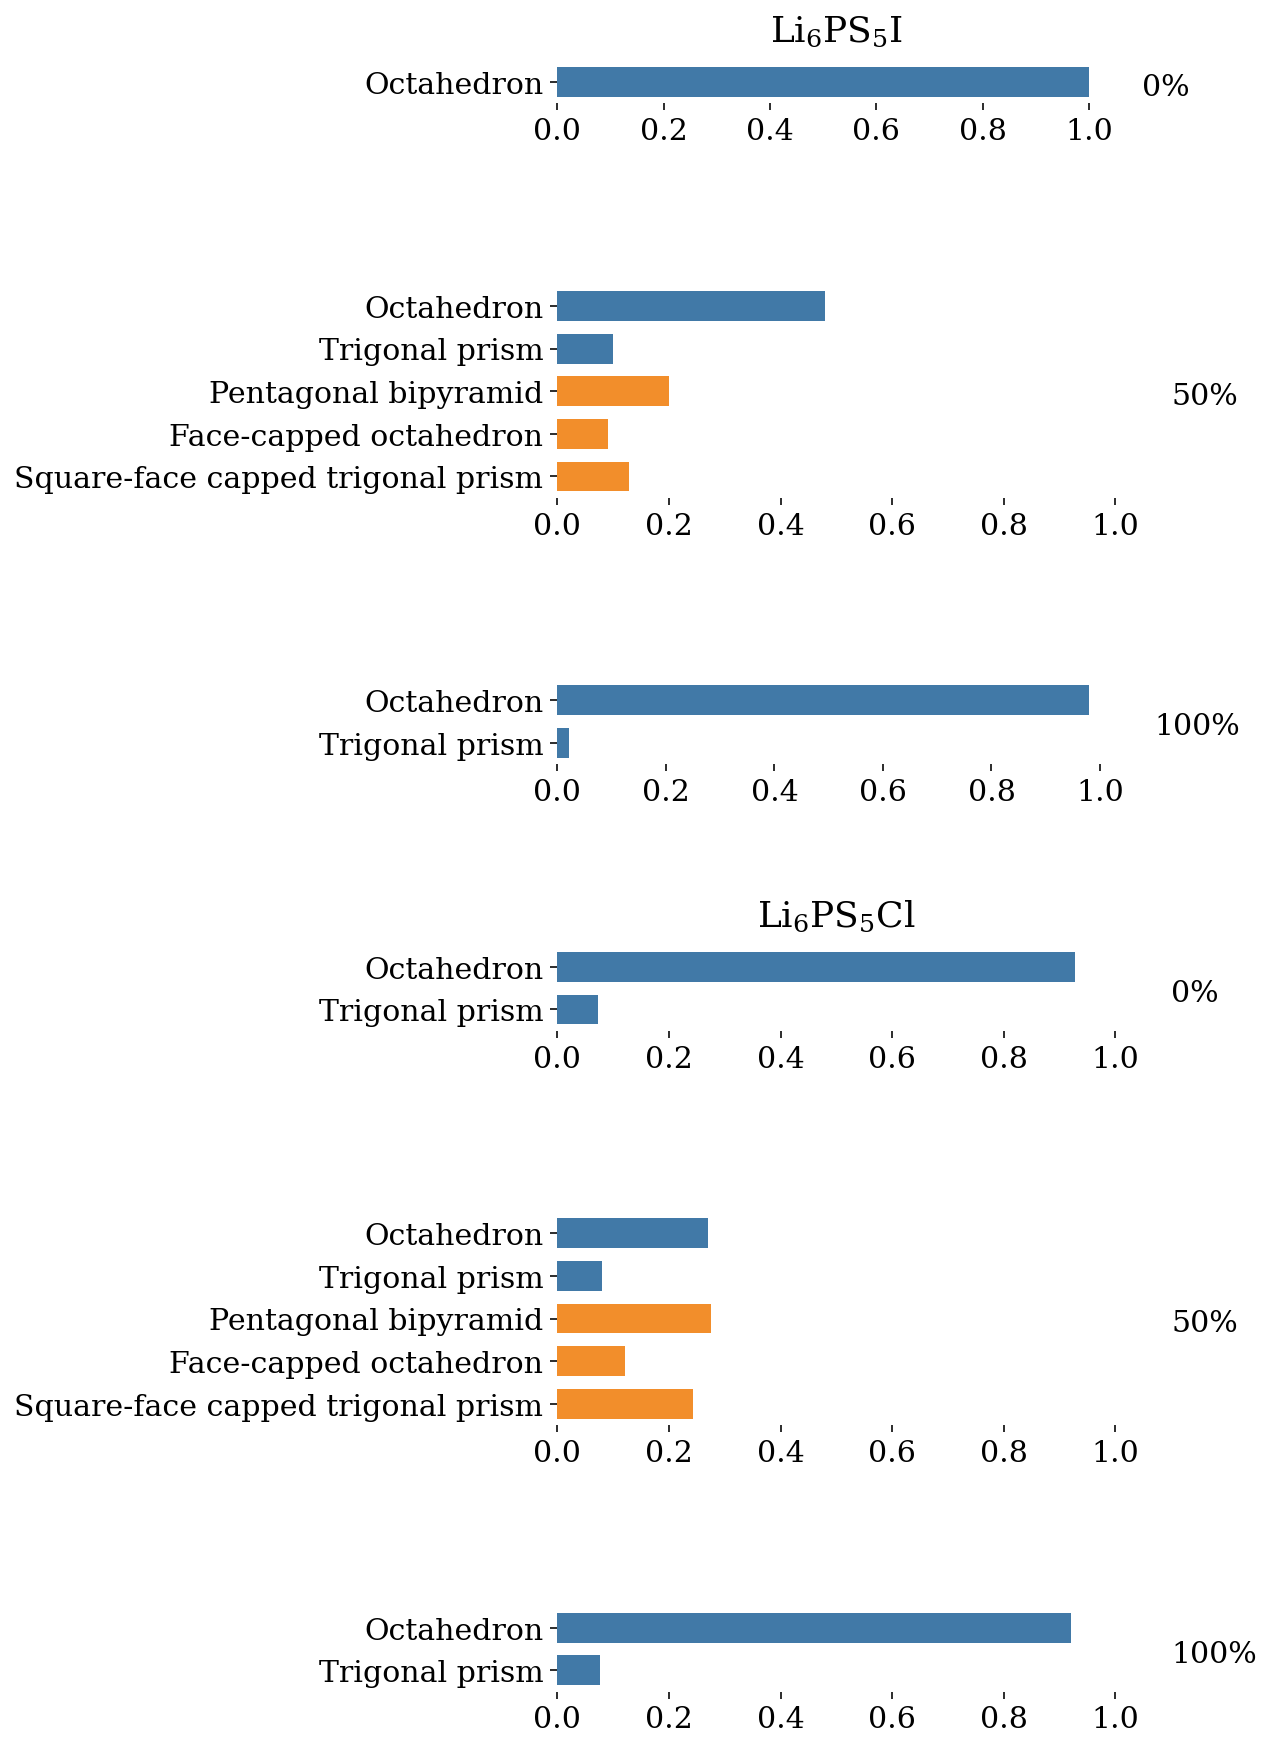

In [62]:
order = {'Octahedron': 4, 
         'Trigonal prism': 3,
         'Pentagonal bipyramid': 2,
         'Face-capped octahedron': 1, 
         'Square-face capped trigonal prism': 0}

i = 0

c1 = '#4179a7'
c2 = '#f28e2b'
col = {'Octahedron': c1,
       'Trigonal prism': c1,
       'Pentagonal bipyramid': c2,
       'Face-capped octahedron': c2, 
       'Square-face capped trigonal prism': c2}

to_plot = {}
for system in ['Li6PS5I', 'Li6PS5Cl']:
    to_plot[system] = {}
    for disorder in ['0p', '50p', '100p']:
        threshold = 0.01
        data = bfg_data[system][disorder]
        c = Counter( g['geometry'] for g in data )
        total = sum(c.values(), 0.0)
        for key in c:
            c[key] /= total
        labels = []
        values = []
        for l, v in c.items():
            if v >= threshold:
                labels.append(l)
                values.append(v)
        labels, values = zip(*sorted(zip(labels, values), key=lambda x: order[x[0]]))
        colors = [ col[l] for l in labels ]
        to_plot[system][disorder] = {'labels': labels, 'values': values, 
                                     'n': len(values), 'colors': colors}

subplot_heights = []
for system in ['Li6PS5I', 'Li6PS5Cl']:
    for disorder in [ '0p', '50p', '100p' ]:
        subplot_heights.append(to_plot[system][disorder]['n'])
        
title = {'Li6PS5Cl': r'Li$_6$PS$_5$Cl',
         'Li6PS5I': r'Li$_6$PS$_5$I'}  
title_disorder = {'0p': '0%',
                  '50p': '50%',
                  '100p': '100%'}
fig, ax = plt.subplots(6,1 , gridspec_kw={'height_ratios': subplot_heights, 
                                         'hspace': 1.5}, figsize=(5,15) )
for system in ['Li6PS5I', 'Li6PS5Cl']:
    for disorder in ['0p', '50p', '100p']:
        p = to_plot[system][disorder]
        indexes = np.arange(len(p['labels']))
        height = 0.7

#         ax[i].figure(figsize=(8, 1*len(indexes)))
        ax[i].barh(indexes, p['values'], height, color=p['colors'], antialiased=True )
#         ax[i].barh(indexes, p['values'], height, color=p['colors'], edgecolor=None, alpha=0.5 )
        ax[i].set_ylim([-0.5,p['n']-0.5])
        ax[i].set_yticks(indexes)
        ax[i].set_yticklabels(p['labels'])
        ax[i].set_xticks(np.linspace(0,1,6))
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['left'].set_visible(False)
        ax[i].spines['bottom'].set_visible(False)
        if i in  [0,3]:
            ax[i].set_title(f'{title[system]}', pad=10)
        ax[i].text(1.1,p['n']/2.0-0.8,f'{title_disorder[disorder]}')
        i+=1
fig.tight_layout()
# plt.gcf().subplots_adjust(left=0.0, right=1.0)
fig.savefig('../../figures/polyhedra_types.pdf', bbox_inches='tight')
fig.show()

In [ ]:
from scipy.stats import gaussian_kde

order = {'Octahedron': 4, 
         'Trigonal prism': 3,
         'Pentagonal bipyramid': 2,
         'Face-capped octahedron': 1, 
         'Square-face capped trigonal prism': 0}

color = {'Octahedron': '#4179a7',
        'Trigonal prism': '#f28e2b',
        'Pentagonal bipyramid': '#59a14f',
        'Face-capped octahedron': '#ef9da7', 
        'Square-face capped trigonal prism': '#bab0ac',
        'Total': '#9f9f9f'}

fig, ax = plt.subplots(3,2,figsize=(10,10))

def plot_sm(axes, sm, label=None, color=None, linestyle=None):
    kde = gaussian_kde(sm, bw_method=0.05)
    xs = np.linspace(0.0,15.0,200)
    ys = kde(xs)*len(sm)
#     axes.hist( distances, bins=100, alpha=0.5, label=label, density=True )
    l = axes.plot(xs, ys, antialiased=True, linewidth=2, color=color, linestyle=linestyle)
    if label is not 'Total':
        l = axes.fill_between(xs, ys, alpha=.5, zorder=5, antialiased=True, color=color, label=label)
#     axes.legend(fancybox=False, loc='upper right', frameon=False)
    

sm = np.array([ d['symmetry_measure'] for d in bfg_data['Li6PS5I']['0p'] if d['geometry']=='Octahedron'])
plot_sm(ax[0,0], sm, label=f'Octahedra', color=color['Octahedron'], linestyle='-')
sm = np.array([ d['symmetry_measure'] for d in bfg_data['Li6PS5I']['0p'] if d['geometry']=='Trigonal prism'])
plot_sm(ax[0,0], sm, label=f'Trigonal prisms', color=color['Trigonal prism'], linestyle='-')
sm = np.array([ d['symmetry_measure'] for d in bfg_data['Li6PS5I']['0p']])
plot_sm(ax[0,0], sm, label=f'Total', color=color['Total'], linestyle='--')

sm = np.array([ d['symmetry_measure'] for d in bfg_data['Li6PS5I']['50p'] if d['geometry']=='Octahedron'])
plot_sm(ax[1,0], sm, label=f'Octahedra', color=color['Octahedron'], linestyle='-')
sm = np.array([ d['symmetry_measure'] for d in bfg_data['Li6PS5I']['50p'] if d['geometry']=='Trigonal prism'])
plot_sm(ax[1,0], sm, label=f'Trigonal prisms', color=color['Trigonal prism'], linestyle='-')
sm = np.array([ d['symmetry_measure'] for d in bfg_data['Li6PS5I']['50p'] if d['geometry']=='Pentagonal bipyramid'])
plot_sm(ax[1,0], sm, label=f'Pentagonal bipyramid', color=color['Pentagonal bipyramid'], linestyle='-')
sm = np.array([ d['symmetry_measure'] for d in bfg_data['Li6PS5I']['50p'] if d['geometry']=='Face-capped octahedron'])
plot_sm(ax[1,0], sm, label=f'Face-capped octahedron', color=color['Face-capped octahedron'], linestyle='-')
sm = np.array([ d['symmetry_measure'] for d in bfg_data['Li6PS5I']['50p'] if d['geometry']=='Square-face capped trigonal prism'])
plot_sm(ax[1,0], sm, label=f'Square-face capped trigonal prism', color=color['Square-face capped trigonal prism'], linestyle='-')
sm = np.array([ d['symmetry_measure'] for d in bfg_data['Li6PS5I']['50p']])
plot_sm(ax[1,0], sm, label=f'Total', color=color['Total'], linestyle='--')

sm = np.array([ d['symmetry_measure'] for d in bfg_data['Li6PS5I']['100p'] if d['geometry']=='Octahedron'])
plot_sm(ax[2,0], sm, label=f'Octahedra', color=color['Octahedron'], linestyle='-')
sm = np.array([ d['symmetry_measure'] for d in bfg_data['Li6PS5I']['100p'] if d['geometry']=='Trigonal prism'])
plot_sm(ax[2,0], sm, label=f'Trigonal prisms', color=color['Trigonal prism'], linestyle='-')
sm = np.array([ d['symmetry_measure'] for d in bfg_data['Li6PS5I']['100p']])
plot_sm(ax[2,0], sm, label=f'Total', color=color['Total'], linestyle='--')

sm = np.array([ d['symmetry_measure'] for d in bfg_data['Li6PS5Cl']['0p'] if d['geometry']=='Octahedron'])
plot_sm(ax[0,1], sm, label=f'Octahedra', color=color['Octahedron'], linestyle='-')
sm = np.array([ d['symmetry_measure'] for d in bfg_data['Li6PS5Cl']['0p'] if d['geometry']=='Trigonal prism'])
plot_sm(ax[0,1], sm, label=f'Trigonal prisms', color=color['Trigonal prism'], linestyle='-')
sm = np.array([ d['symmetry_measure'] for d in bfg_data['Li6PS5Cl']['0p']])
plot_sm(ax[0,1], sm, label=f'Total', color=color['Total'], linestyle='--')

sm = np.array([ d['symmetry_measure'] for d in bfg_data['Li6PS5Cl']['50p'] if d['geometry']=='Octahedron'])
plot_sm(ax[1,1], sm, label=f'Octahedra', color=color['Octahedron'], linestyle='-')
sm = np.array([ d['symmetry_measure'] for d in bfg_data['Li6PS5Cl']['50p'] if d['geometry']=='Trigonal prism'])
plot_sm(ax[1,1], sm, label=f'Trigonal prisms', color=color['Trigonal prism'], linestyle='-')
sm = np.array([ d['symmetry_measure'] for d in bfg_data['Li6PS5Cl']['50p'] if d['geometry']=='Pentagonal bipyramid'])
plot_sm(ax[1,1], sm, label=f'Pentagonal bipyramid', color=color['Pentagonal bipyramid'], linestyle='-')
sm = np.array([ d['symmetry_measure'] for d in bfg_data['Li6PS5Cl']['50p'] if d['geometry']=='Face-capped octahedron'])
plot_sm(ax[1,1], sm, label=f'Face-capped octahedron', color=color['Face-capped octahedron'], linestyle='-')
sm = np.array([ d['symmetry_measure'] for d in bfg_data['Li6PS5Cl']['50p'] if d['geometry']=='Square-face capped trigonal prism'])
plot_sm(ax[1,1], sm, label=f'Square-face capped trigonal prism', color=color['Square-face capped trigonal prism'], linestyle='-')
sm = np.array([ d['symmetry_measure'] for d in bfg_data['Li6PS5Cl']['50p']])
plot_sm(ax[1,1], sm, label=f'Total', color=color['Total'], linestyle='--')

sm = np.array([ d['symmetry_measure'] for d in bfg_data['Li6PS5Cl']['100p'] if d['geometry']=='Octahedron'])
plot_sm(ax[2,1], sm, label=f'Octahedra', color=color['Octahedron'], linestyle='-')
sm = np.array([ d['symmetry_measure'] for d in bfg_data['Li6PS5Cl']['100p'] if d['geometry']=='Trigonal prism'])
plot_sm(ax[2,1], sm, label=f'Trigonal prisms', color=color['Trigonal prism'], linestyle='-')
sm = np.array([ d['symmetry_measure'] for d in bfg_data['Li6PS5Cl']['100p']])
plot_sm(ax[2,1], sm, label=f'Total', color=color['Total'], linestyle='--')

for i in range(3):
    for j in range(2):
        ax[i,j].set_xlim([0.0,12.5])
#         ax[i,j].set_ylim([0.0,5000.0])
        ax[i,j].set_yticks([])
        
xlabel = r'$S$'
ylabel = r'$P(S)$'
ax[0,0].set_title(r'Li$_6$PS$_5$I', pad=15)
ax[0,1].set_title(r'Li$_6$PS$_5$Cl', pad=15)
ax[2,0].set(xlabel=xlabel, ylabel=ylabel)
ax[1,0].set(ylabel=ylabel)
ax[0,0].set(ylabel=ylabel)
ax[1,1].set(ylabel=ylabel)
ax[0,1].set(ylabel=ylabel)
ax[2,1].set(xlabel=xlabel, ylabel=ylabel)

ax[0,1].text(13.0,2.0,'0 %')
ax[1,1].text(13.0,2.0,'50 %')
ax[2,1].text(13.0,2.0,'100 %')
        
plt.tight_layout()
plt.savefig('../../figures/polyhedral_symmetry_measures.pdf')
plt.show()